In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Read the NetCDF file containing temperature data
nc_file = '2m_temperature_nanjing.nc'
ds = xr.open_dataset(nc_file)

In [2]:
# Extract data for Nanjing by finding the closest lat/lon point
lat_idx = np.argmin(np.abs(ds.latitude.values - 32.06))  # Nanjing latitude
lon_idx = np.argmin(np.abs(ds.longitude.values - 118.79))  # Nanjing longitude
nanjing_temp = ds.t2m.isel(latitude=lat_idx, longitude=lon_idx)

# Convert xarray DataArray to pandas DataFrame
df = nanjing_temp.to_dataframe().reset_index()
df = df.set_index('valid_time')  # Set the time column as index
df = df[['t2m']]  # Select only the temperature column
df.columns = ['temperature']  # Rename the column for clarity
df['temperature'] = df['temperature'] - 273.15  # Convert from Kelvin to Celsius

# Step 2: Preprocess the data: Normalize using MinMaxScaler

In [3]:
# Extract data for Nanjing by finding the closest lat/lon point
lat_idx = np.argmin(np.abs(ds.latitude.values - 32.06))  # Nanjing latitude
lon_idx = np.argmin(np.abs(ds.longitude.values - 118.79))  # Nanjing longitude
nanjing_temp = ds.t2m.isel(latitude=lat_idx, longitude=lon_idx)

# Convert xarray DataArray to pandas DataFrame
df = nanjing_temp.to_dataframe().reset_index()
df = df.set_index('valid_time')  # Set the time column as index
df = df[['t2m']]  # Select only the temperature column
df.columns = ['temperature']  # Rename the column for clarity
df['temperature'] = df['temperature'] - 273.15  # Convert from Kelvin to Celsius

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Step 3: Create sequences for time series prediction

In [4]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 20):  # Slide the window to leave space for 20 days prediction
        X.append(data[i:(i + seq_length), 0])
        y.append(data[(i + seq_length):(i + seq_length + 20), 0])  # Predict next 20 days
    return np.array(X), np.array(y)

# Create sequences with length 3 for prediction
seq_length = 3  # Use 3 time steps to predict the next 20 time steps
X, y = create_sequences(scaled_data, seq_length)


# Step 4: Split the data into training and testing sets

In [5]:
train_size = len(X) - 240  # Use the last 240 days as the test set
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert numpy arrays to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Add a third dimension to the input for LSTM (batch_size, seq_length, input_size)
X_train = X_train.unsqueeze(2)  # Shape becomes (batch_size, seq_length, input_size)
X_test = X_test.unsqueeze(2)    # Shape becomes (batch_size, seq_length, input_size)

# Step 5: Create DataLoader for batch processing during training

In [6]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Step 6: Define the LSTM model

In [7]:
# Step 6: Define the LSTM model to predict 20 days of temperature
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=20):  # Output size is now 20
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))  # Corrected the issue here, removing detach()
        out = self.fc(out[:, -1, :])  # Use the last timestep's output for prediction
        return out


## Step 7: Initialize the model, loss function, and optimizer

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=20).to(device)  # Output size 20
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Step 8: Train the model

In [9]:
# Step 8: Train the model
num_epochs = 100
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)  # Now batch_y is the correct shape with 20 steps

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/100], Loss: 0.0302
Epoch [2/100], Loss: 0.0088
Epoch [3/100], Loss: 0.0088
Epoch [4/100], Loss: 0.0088
Epoch [5/100], Loss: 0.0087
Epoch [6/100], Loss: 0.0086
Epoch [7/100], Loss: 0.0086
Epoch [8/100], Loss: 0.0085
Epoch [9/100], Loss: 0.0083
Epoch [10/100], Loss: 0.0081
Epoch [11/100], Loss: 0.0080
Epoch [12/100], Loss: 0.0080
Epoch [13/100], Loss: 0.0079
Epoch [14/100], Loss: 0.0078
Epoch [15/100], Loss: 0.0078
Epoch [16/100], Loss: 0.0079
Epoch [17/100], Loss: 0.0077
Epoch [18/100], Loss: 0.0077
Epoch [19/100], Loss: 0.0078
Epoch [20/100], Loss: 0.0077
Epoch [21/100], Loss: 0.0077
Epoch [22/100], Loss: 0.0077
Epoch [23/100], Loss: 0.0077
Epoch [24/100], Loss: 0.0077
Epoch [25/100], Loss: 0.0077
Epoch [26/100], Loss: 0.0077
Epoch [27/100], Loss: 0.0076
Epoch [28/100], Loss: 0.0077
Epoch [29/100], Loss: 0.0077
Epoch [30/100], Loss: 0.0076
Epoch [31/100], Loss: 0.0076
Epoch [32/100], Loss: 0.0076
Epoch [33/100], Loss: 0.0076
Epoch [34/100], Loss: 0.0076
Epoch [35/100], Loss: 0

## Step 9: Make predictions

In [10]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train.to(device)).cpu().numpy()
    test_predict = model(X_test.to(device)).cpu().numpy()

# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.numpy())
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.numpy())

## Step 10: Calculate RMSE

In [11]:
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv) ** 2))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 3.57
Test RMSE: 4.24


# Step 11: Visualize the results

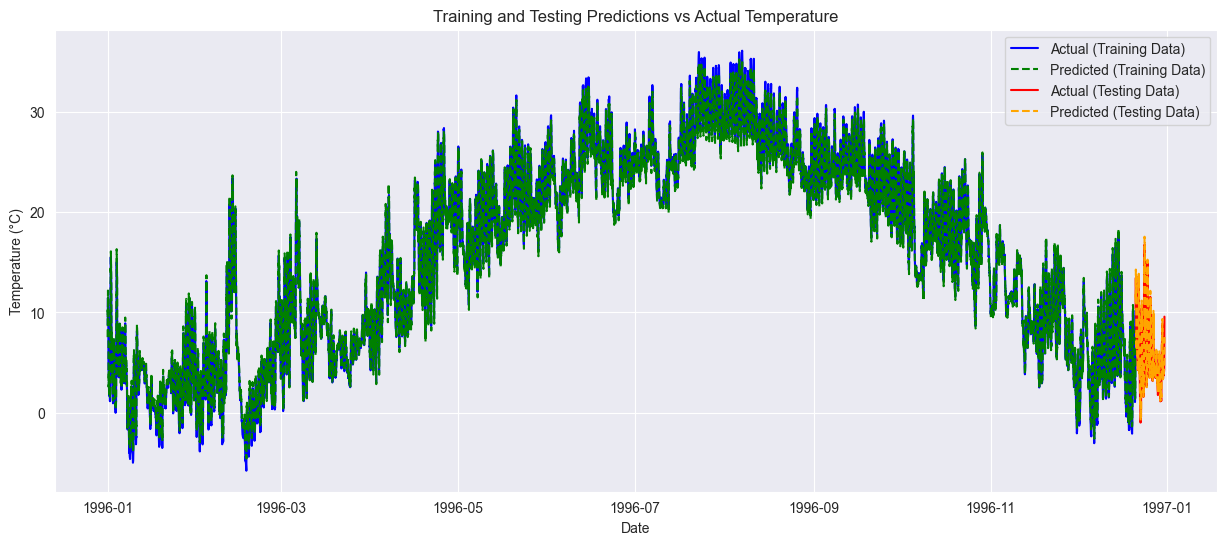

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(df.index[:train_size], y_train_inv[:, 0], label='Actual (Training Data)', color='blue')
plt.plot(df.index[:train_size], train_predict[:, 0], label='Predicted (Training Data)', color='green', linestyle='dashed')
plt.plot(df.index[train_size:train_size+len(y_test_inv)], y_test_inv[:, 0], label='Actual (Testing Data)', color='red')
plt.plot(df.index[train_size:train_size+len(test_predict)], test_predict[:, 0], label='Predicted (Testing Data)', color='orange', linestyle='dashed')
plt.title('Training and Testing Predictions vs Actual Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Step 12: Loss Function Plot

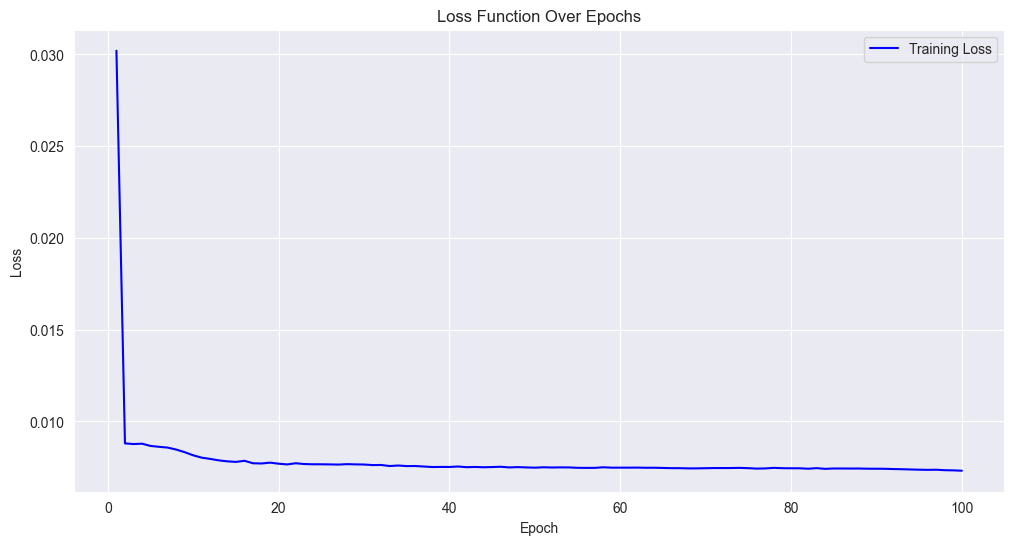

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label='Training Loss', color='blue')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: torch.Size([8541, 3, 1])
y_train shape: torch.Size([8541, 1])
